<h1>PROJETO 2 | TESTE A/B</h1>
<h3>Lucas Fontenla & Raphael Costa</h3>
_______________________________________

<ol>
<h3><li>Resumo</li></h3>
<p>Para o segundo projeto de Ciência dos Dados, fomos instruídos a avaliar duas versões diferentes de um website<p>
<p>Nós escolhemos o portfolio utilizado para o curso de Co-Design de Aplicativos, disponível nesse <a href="http://cd-teste-ab.firebaseapp.com">link.</a></p>

<h3><li>Projeto</li></h3>
<p>Foram criadas duas versões do site, ambas com a primeira página igual. As páginas da aba "Projeto" são diferentes no método de categorização dos projetos. Na versão A, o usuário precisa dar um "scroll down" na página, e há uma subcategoria que especifica mais qual o projeto. Na versão B, as categorias estão organizadas em blocos, direto na página.</p>
<p>As páginas seguintes foram modificadas muito pouco, e de maneira geral, são muito próximas.</p>
<h4>Veja páginas abaixo:</h4>

<center><h4>Versão A</h4></center>
<img src="img/projetos_vA.png" width="600">

<center><h4>Versão B</h4></center>
<img src="img/projetos_vB.png" width="600">

<h3><li>Dinâmica da Análise</li></h3>
<p>Logo na página de abertura, são sorteadas duas páginas, A e B, como mencionado acima, e ainda, outros dois projetos, "Como evacuar um arranha-céu rapidamente" de ModSim ou "Singularity - NASA" de GDE.</p>
<p>Em seguida, são medidos os tempos que o usuário leva para achar a categoria certa do projeto, o tempo para achar o projeto depois de achar a categoria e o tempo total desde o início até achar o projeto.<p>
<p><strong>Por que escolhemos dois projetos?</strong></p><p>Escolhemos dois projetos por conta da dificuldade. O Projeto de ModSim tem uma maior facilidade de ser encontrado por conta do nome da matéria e do nome da categoria. Já o de GDE, não é muito fácil de identificar a categoria correta, ou seja, estamos avaliando uma melhor versão para ambas as dificuldades</p>

<h3><li>A Análise Estatística</li></h3>
<p>A análise será feita com base no <strong>Teorema do Limite Central (TLC)</strong>, sendo a exata ferramenta discutida mais a frente, dependendo do número de amostras que obtivermos.</p>
<p>Caso as amostras sejam muito pequenas, vamos optar pela distribuição t-Student, o contrário, caso as amostras sejam maiores que n=30, vamos optar pela curva normal.</p>

<h3>PARTE 1 | Importando a base de dados do Firebase, calculando delta_t e montando o DataFrame</h3>

In [1]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
%matplotlib inline

In [2]:
with open('data/cd-teste-ab-export.json') as data_file:    
    data = json.load(data_file)
    
data = data['logs']

resultados = list()

for key in data.keys():
    resultados.append(data[key])
    
data = pd.DataFrame(resultados)

data['user_id'] = data['user_id'].apply(pd.to_numeric)

data.head()

,projeto,tempo,tipo,user_id,versao
0,GDE,1478488665272,escolha_categoria,655675346,A
1,ModSim,1478490028035,escolha_categoria,655675346,B
2,GDE,1478489799285,escolha_categoria,655675346,B
3,ModSim,1478524727496,inicio,655675346,A
4,GDE,1478488417247,escolha_categoria,655675346,B


In [3]:
agrupado = data.groupby(by=["user_id", "versao"])

In [4]:
users = set(data.user_id)

In [5]:
users = list(users)

In [6]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        for proj in data[data.user_id ==  u].projeto:
            if (u, versao) in agrupado.groups.keys(): 
                grupo1 =  agrupado.get_group((u, versao))
                grupo1 = grupo1.sort_values(by="tempo") 

                if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1 and len(grupo1[grupo1.tipo=="escolha_categoria"]) >= 1:
                    delta_t1 = grupo1[grupo1.tipo=="escolha_categoria"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                    delta_t2 = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="escolha_categoria"].iloc[0].tempo
                    delta_t3 = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                    
                    resultados.append({"user_id":u, "delta_t_cat":delta_t1, "delta_t_final":delta_t2, "delta_t":delta_t3, "versao":versao, "projeto":proj})

In [7]:
grupo1.sort_values(by="tempo")
data = pd.DataFrame(resultados)

In [8]:
data.delta_t_cat/=1000
data.delta_t_final/=1000
data.delta_t/=1000

In [9]:
A = data.delta_t_cat.dropna
B = data.delta_t_final.dropna
C = data.delta_t.dropna

In [10]:
data.head()

,delta_t,delta_t_cat,delta_t_final,projeto,user_id,versao
0,3493.748,227543.37,3424.403,ModSim,4122330881,A
1,3493.748,227543.37,3424.403,GDE,4122330881,A
2,3493.748,227543.37,3424.403,ModSim,4122330881,A
3,3493.748,227543.37,3424.403,ModSim,4122330881,A
4,3493.748,227543.37,3424.403,GDE,4122330881,A


<h3>PARTE 2 | Conhecendo um pouco os dados colhidos</h3>


DISTRIBUIÇÃO DAS VERSÕES E PROJETOS ALEATÓRIOS



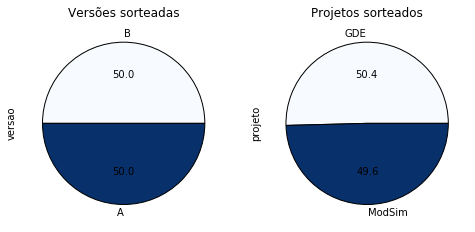

In [11]:
print('\nDISTRIBUIÇÃO DAS VERSÕES E PROJETOS ALEATÓRIOS\n')

plt.subplot(221)
plt.title('Versões sorteadas')
data.versao.value_counts().plot(kind='pie', colormap='Blues', autopct='%.1f', figsize=(8,8))

plt.subplot(222)
plt.title('Projetos sorteados')
data.projeto.value_counts().plot(kind='pie', colormap='Blues', autopct='%.1f', figsize=(8,8))

plt.show()

<p>Os gráficos acima nos mostram que usando a função aleatória no script do site, conseguimos uma distribuição muito bem equilibrada, com exatamente 50% em cada versão, e muito próximo da metade nos projetos.</p>

In [12]:
#Filtragem de dados - Vimos que alguém deixou um tempo absurdo aberto
vA = data[(data.versao == "A") & (data.delta_t < 3000)]
vB = data[(data.versao == "B") & (data.delta_t < 3000)]

#VERSÃO A - cálculo de média e variância
mu_Ta = vA.delta_t.mean()
s_Ta = vA.delta_t.var()

mu_cata = vA.delta_t_cat.mean()
s_cata = vA.delta_t_cat.var()

mu_fa = vA.delta_t_final.mean()
s_fa = vA.delta_t_final.var()

print("""
VERSÃO A

Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_Ta, s_Ta, mu_cata, s_cata, mu_fa, s_fa))
print("Tamanho da Amostra em A: ", vA.shape[0])

#VERSÃO B - cálculo de média e variância
mu_Tb = vB.delta_t.mean()
s_Tb = vB.delta_t.var()

mu_catb = vB.delta_t_cat.mean()
s_catb = vB.delta_t_cat.var()

mu_fb = vB.delta_t_final.mean()
s_fb = vB.delta_t_final.var()

print("""
\n\nVERSÃO B

Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_Tb, s_Tb, mu_catb, s_catb, mu_fb, s_fb))
print("Tamanho da Amostra em B: ", vB.shape[0])


VERSÃO A

Média (Delta T): 85.64616666666664
Variância (Delta T): 6088.737707459349

Média (Delta T Categoria-Inicial): 80.15895238095234
Variância (Delta T Categoria-Inicial): 5688.331528631821

Média (Delta T Final-Categoria): 21.17483333333333
Variância (Delta T Final-Categoria): 1029.0036415081308
Tamanho da Amostra em A:  42



VERSÃO B

Média (Delta T): 30.755714285714294
Variância (Delta T): 162.93301356221198

Média (Delta T Categoria-Inicial): 18.475634920634917
Variância (Delta T Categoria-Inicial): 140.9557845581157

Média (Delta T Final-Categoria): 95.54341269841271
Variância (Delta T Final-Categoria): 16956.703371181782
Tamanho da Amostra em B:  63


<h4>O que as medidas de tendência central e dispersão nos mostram?</h4>
<p>A partir da análise dos valores, vimos que realmente a média é muito próxima entre as diferentes versões, mas, há de se notar o desvio padrão das amostras.<p>

<h3>PARTE 3 | Inferências estatísticas</h3>
<p>Para amostras com um número de elementos superior a 30, é plausível usarmos o TLC (Teorema do Limite Central) como inferência estatística. Desse modo, serão levantadas duas curvas normais, uma da versão A e outra da B, de modo a encontrar qual delas seria a melhor versão.</p>
<p>Procedimento de análise:</p>
<ol>
<li>Levantamento das curvas normais das versões A e B</li>
<li>Construção da região crítica e intervalo de confiança</li>
<li>Check I (pré-conclusão) das análises feitas</li>
<li>Levantamento das curvas por projeto em cada versão</li>
<li>Construção da região crítica e intervalo de confiança</li>
<li>Check II das análises feitas</li>
<li>Conclusão</li>
</ol>
<h3>As Hipóteses</h3>
<p><strong>Hipótese Nula- H0:</strong> Média de tempo de B < média de tempo de A</p>
<p><strong>Hipótese Alternativa - Ha:</strong> Média de tempo de B >= média de tempo A</p>
<h3>3.1 | Curvas Normais</h3>

VERSÃO A


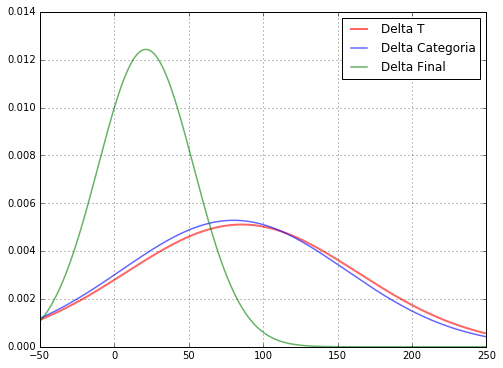

VERSÃO B


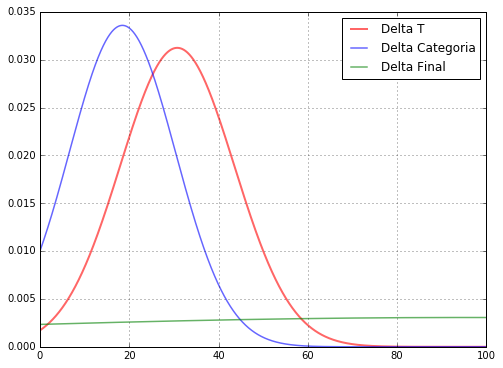

In [28]:
x = np.linspace(-50, 250, 100000)
y_T = stats.norm.pdf(x, loc=mu_Ta, scale=math.sqrt(s_Ta))
y_cat = stats.norm.pdf(x, loc=mu_cata, scale=math.sqrt(s_cata))
y_f = stats.norm.pdf(x, loc=mu_fa, scale=math.sqrt(s_fa))

print("VERSÃO A")

plt.figure(figsize=(8, 6))
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T", color="r")
plt.plot(x, y_cat, lw=1.5, alpha=0.6, label="Delta Categoria", color="b")
plt.plot(x, y_f, lw=1.5, alpha=0.6, label="Delta Final", color="g")
plt.legend(loc='best')
plt.grid()

plt.show()
#________________________________________________________________________________________________________________________________

x = np.linspace(0, 100, 10000)
y_T = stats.norm.pdf(x, loc=mu_Tb, scale=math.sqrt(s_Tb))
y_cat = stats.norm.pdf(x, loc=mu_catb, scale=math.sqrt(s_catb))
y_f = stats.norm.pdf(x, loc=mu_fb, scale=math.sqrt(s_fb))

print("VERSÃO B")

plt.figure(figsize=(8, 6))
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T", color="r")
plt.plot(x, y_cat, lw=1.5, alpha=0.6, label="Delta Categoria", color="b")
plt.plot(x, y_f, lw=1.5, alpha=0.6, label="Delta Final", color="g")
plt.legend(loc='best')
plt.grid()

plt.show()

<h4>Primeiras observações</h4>
<p>Percebe-se que as curvas normais do tempo total de ambas as versões apresentam um formato diferente, sendo a curva da versão A muito mais "aberta", ou seja, com uma variância muito maior e provavelmente em decorrência do fato de que o tempo para se achar a categoria correta na Versão A é maior que a versão B.</p>
<h3>3.2 | Intervalo de Confiança</h3>

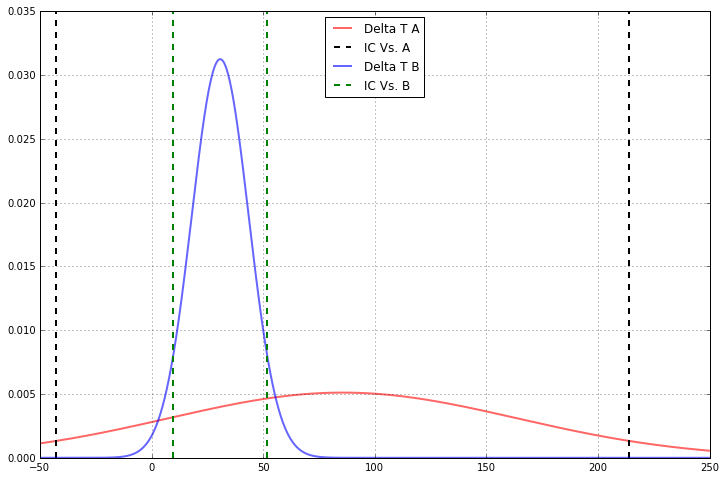


Média A: 85.646
Média B: 30.756

Intervalo de Confiança (95%) A: (-42.702360586748128, 213.99469392008143) - tamanho: 256.69705450682955
Intervalo de Confiança (95%) B: (9.7599445141797965, 51.751484057248788) - tamanho: 41.991539543068995


In [14]:
#Para apenas o DELTA_T
x = np.linspace(-50, 250, 100000)
z95 = stats.norm.ppf(.95, loc=0, scale=1) #gamma de 95%

#A
y_T = stats.norm.pdf(x, loc=mu_Ta, scale=math.sqrt(s_Ta))
IC = ((mu_Ta-z95*math.sqrt(s_Ta), (mu_Ta+z95*math.sqrt(s_Ta))))

#B
y_Tb = stats.norm.pdf(x, loc=mu_Tb, scale=math.sqrt(s_Tb))
ICb = ((mu_Tb-z95*math.sqrt(s_Tb), (mu_Tb+z95*math.sqrt(s_Tb))))

#Start Plot
plt.figure(figsize=(12, 8))
#Plot A
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T A", color="r")
plt.axvline(IC[0], lw=2, ls="dashed", color='black', label="IC Vs. A")
plt.axvline(IC[1], lw=2, ls="dashed", color='black')
#Plot B
plt.plot(x, y_Tb, lw=2, alpha=0.6, label="Delta T B", color="b")
plt.axvline(ICb[0], lw=2, ls="dashed", color='g', label="IC Vs. B")
plt.axvline(ICb[1], lw=2, ls="dashed", color='g')

plt.legend(loc='best')
plt.grid()

plt.show()

print("""
Média A: {0}
Média B: {1}

Intervalo de Confiança (95%) A: {2} - tamanho: {4}
Intervalo de Confiança (95%) B: {3} - tamanho: {5}""".format(round(mu_Ta, 3), round(mu_Tb, 3), IC, ICb, (IC[1]-IC[0]),
                                                             (ICb[1]-ICb[0])))


<h3>3.3 | Check I</h3>
<p>Primeiramente foram definidas as hipóteses nula e alternativa, e com base nelas seguimos o processo de inferência estatística.</p>
<p>Logo no item 3.1 foi possível se observar que talvez a B fosse melhor que a versão A, em relação ao tempo médio para se achar o projeto.</p>
<p>Pelo item 3.2, podemos observar que as médias do tempo total não são próximas, sendo o tempo médio de A mais que o dobro de B e, os intervalos para um coeficiente de confiança de 95% também são muito maiores em A do que em B, ou seja, <strong>não rejeitamos a Hipótese Nula</strong> assim, não rejeitamos a hipótese de que na versão B é muito mais rápido encontrar o projeto do que na versão B.</p>
<p>Vale ressaltar que o "tamanho" expresso no gráfico acima, se refere a distância que o intervalo de confiança preenche</p>

<h3>4 | Curvais normais dos projetos e Intervalos de Confiança</h3>
<p>Sabemos que a versão B é mais eficiente que a versão A, mas, ela é eficiente para ambos os projetos?</p>
<p>Lembrando que foram separados dois projetos, em que o nível de dificuldade é diferente. Para GDE, o nível de dificuldade em achar o projeto é maior do que para ModSim.</p>

In [15]:
### ModSim
mod_A = vA[vA.projeto == "ModSim"]
mod_B = vB[vB.projeto == "ModSim"]

In [16]:
#ModSim versão A
mu_mod_A = mod_A.delta_t.mean()
s_mod_A = mod_A.delta_t.var()

mu_cat_Mod_A = mod_A.delta_t_cat.mean()
s_cat_Mod_A = mod_A.delta_t_cat.var()

mu_fb_Mod_A = mod_A.delta_t_final.mean()
s_fb_Mod_A = mod_A.delta_t_final.var()

print("ModSim versão A\n")
print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_mod_A, s_mod_A, mu_cat_Mod_A, s_cat_Mod_A, mu_fb_Mod_A, s_fb_Mod_A))


#ModSim versão B
mu_mod_B = mod_B.delta_t.mean()
s_mod_B = mod_B.delta_t.var()

mu_cat_Mod_B = mod_B.delta_t_cat.mean()
s_cat_Mod_B = mod_B.delta_t_cat.var()

mu_fb_Mod_B = mod_B.delta_t_final.mean()
s_fb_Mod_B = mod_B.delta_t_final.var()

print("\n\nModSim versão B\n")

print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_mod_B, s_mod_B, mu_cat_Mod_B, s_cat_Mod_B, mu_fb_Mod_B, s_fb_Mod_B))

ModSim versão A

Média (Delta T): 76.76983333333332
Variância (Delta T): 5343.270785971012

Média (Delta T Categoria-Inicial): 70.31400000000004
Variância (Delta T Categoria-Inicial): 4701.914014434785

Média (Delta T Final-Categoria): 25.81533333333333
Variância (Delta T Final-Categoria): 1467.4157205797108


ModSim versão B

Média (Delta T): 26.958885714285703
Variância (Delta T): 163.66645416302526

Média (Delta T Categoria-Inicial): 16.144599999999997
Variância (Delta T Categoria-Inicial): 74.16605807058822

Média (Delta T Final-Categoria): 67.90914285714283
Variância (Delta T Final-Categoria): 13494.505052949575


In [17]:
#GDE
gde_A = vA[vA.projeto == "GDE"]
gde_B = vB[vB.projeto == "GDE"]

In [18]:
#GDE versão A
mu_gde_A = gde_A.delta_t.mean()
s_gde_A = gde_A.delta_t.var()

mu_cat_gde_A = gde_A.delta_t_cat.mean()
s_cat_gde_A = gde_A.delta_t_cat.var()

mu_fb_gde_A = gde_A.delta_t_final.mean()
s_fb_gde_A = gde_A.delta_t_final.var()

print("GDE versão A\n")
print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_gde_A, s_gde_A, mu_cat_gde_A, s_cat_gde_A, mu_fb_gde_A, s_fb_gde_A))

#GDE versão B
mu_gde_B = gde_B.delta_t.mean()
s_gde_B = gde_B.delta_t.var()

mu_cat_gde_B = gde_B.delta_t_cat.mean()
s_cat_gde_B = gde_B.delta_t_cat.var()

mu_fb_gde_B = gde_B.delta_t_final.mean()
s_fb_gde_B = gde_B.delta_t_final.var()

print("\n\nGDE versão B\n")
print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_gde_B, s_gde_B, mu_cat_gde_B, s_cat_gde_B, mu_fb_gde_B, s_fb_gde_B))

GDE versão A

Média (Delta T): 97.4812777777778
Variância (Delta T): 7195.930440918299

Média (Delta T Categoria-Inicial): 93.28555555555553
Variância (Delta T Categoria-Inicial): 7038.228085202612

Média (Delta T Final-Categoria): 14.987500000000004
Variância (Delta T Final-Categoria): 425.4511926176472


GDE versão B

Média (Delta T): 35.50175
Variância (Delta T): 125.99758175

Média (Delta T Categoria-Inicial): 21.389428571428574
Variância (Delta T Categoria-Inicial): 214.43358958730167

Média (Delta T Final-Categoria): 130.08624999999992
Variância (Delta T Final-Categoria): 19717.21384175


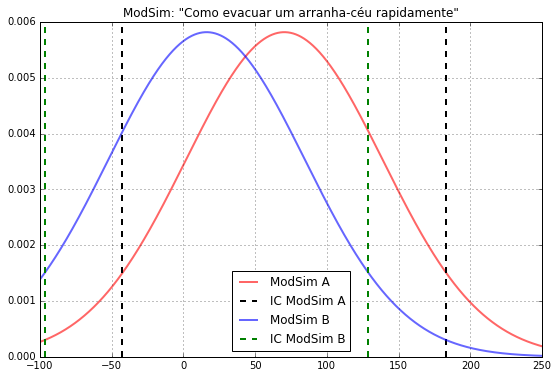

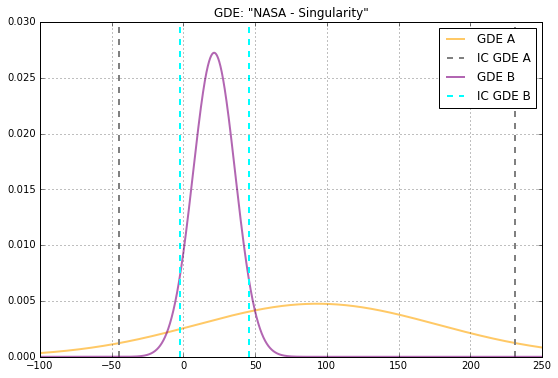

In [19]:
#Para apenas o DELTA_T
x = np.linspace(-100, 250, 100000)
z95 = stats.norm.ppf(.95, loc=0, scale=1) #gamma de 95%

#A
y_MSA = stats.norm.pdf(x, loc=mu_cat_Mod_A, scale=math.sqrt(s_cat_Mod_A))
ICmsA = ((mu_cat_Mod_A-z95*math.sqrt(s_cat_Mod_A), (mu_cat_Mod_A+z95*math.sqrt(s_cat_Mod_A))))

y_TgdeA = stats.norm.pdf(x, loc=mu_cat_gde_A, scale=math.sqrt(s_cat_gde_A))
ICgdeA = ((mu_cat_gde_A-z95*math.sqrt(s_cat_gde_A), (mu_cat_gde_A+z95*math.sqrt(s_cat_gde_A))))

#B
y_MSB = stats.norm.pdf(x, loc=mu_cat_Mod_B, scale=math.sqrt(s_cat_Mod_A))
ICmsB = ((mu_cat_Mod_B-z95*math.sqrt(s_cat_Mod_A), (mu_cat_Mod_B+z95*math.sqrt(s_cat_Mod_A))))

y_TgdeB = stats.norm.pdf(x, loc=mu_cat_gde_B, scale=math.sqrt(s_cat_gde_B))
ICgdeB = ((mu_cat_gde_B-z95*math.sqrt(s_cat_gde_B), (mu_cat_gde_B+z95*math.sqrt(s_cat_gde_B))))

#Start Plot
plt.figure(figsize=(9, 6))
#Plot A
plt.plot(x, y_MSA, lw=2, alpha=0.6, label="ModSim A", color="r")
plt.axvline(ICmsA[0], lw=2, ls="dashed", color='black', label="IC ModSim A")
plt.axvline(ICmsA[1], lw=2, ls="dashed", color='black')

plt.plot(x, y_MSB, lw=2, alpha=0.6, label="ModSim B", color="b")
plt.axvline(ICmsB[0], lw=2, ls="dashed", color='g', label="IC ModSim B")
plt.axvline(ICmsB[1], lw=2, ls="dashed", color='g')

plt.legend(loc='best')
plt.title('ModSim: "Como evacuar um arranha-céu rapidamente"')
plt.grid()

plt.show()

#Plot B
plt.figure(figsize=(9, 6))

plt.plot(x, y_TgdeA, lw=2, alpha=0.6, label="GDE A", color="orange")
plt.axvline(ICgdeA[0], lw=2, ls="dashed", color='grey', label="IC GDE A")
plt.axvline(ICgdeA[1], lw=2, ls="dashed", color='grey')

plt.plot(x, y_TgdeB, lw=2, alpha=0.6, label="GDE B", color="purple")
plt.axvline(ICgdeB[0], lw=2, ls="dashed", color='cyan', label="IC GDE B")
plt.axvline(ICgdeB[1], lw=2, ls="dashed", color='cyan')

plt.legend(loc='best')
plt.title('GDE: "NASA - Singularity"')
plt.grid()

plt.show()

<h3>5 | Check II</h3>
<p>Vemos pelas curvas que realmente a versão B diminuiu o tempo médio em relação a A pelas seguintes observações</p>
<ol>
<li>A curva normal do projeto de ModSim na versão B está deslocada para a esquerda, e tem um aspecto muito similar, ou seja, o tempo médio para se achar a categoria de Modsim é menor na versão B</li>
<li>A curva normal do projeto de GDE tem uma média muito superior na versão A e também há um desvio-padrão muito maior. Já em B, há uma normal muito mais estreita e com uma média menor que a média de A.</li>
</ol>

<h3>PARTE 4 | CONCLUSÃO E VALIDAÇÃO</h3>
<p>Como analisado pelos gráficos, a versão A é menos eficiente que a hipótese B, e assim, podemos <strong>não rejeitar a hipótese nula</strong> e desse modo, podemos inferir que a nova versão do site tem um tempo médio inferior para se achar algum projeto.</p>
<p>Como validação, vamos propor o seguinte teste:<p>
<p>Vamos definir uma nova média, que será dada pela diferença de tempos entre as versões A e B e uma nova variância que será dada pela soma da variância de ambas as versões. A partir de aí, vamos definir que, a nova média é M = Xa - Xb e portanto, podemos calcular qual a probabilidade da distribuição com média M ser maior que 0, pois, indica que a média de tempo de B é menor que a média de tempo de A.</p>

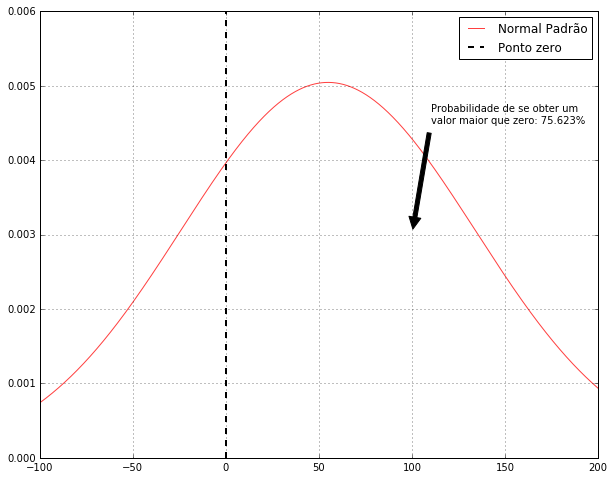

Probabilidade de delta_t_A ser menor que delta_t_B: 75.623%


In [63]:
M = vA.delta_t.mean()-vB.delta_t.mean()
varM = vA.delta_t.var()+vB.delta_t.var()

x = np.linspace(-100, 200, 10000)
y = stats.norm.pdf(x, loc=M, scale=math.sqrt(varM))

plt.figure(figsize=(10,8))
plt.plot(x, y, color='r', alpha=0.75, label='Normal Padrão')
plt.axvline(0, label='Ponto zero', ls='dashed', lw=2, color='black')
plt.annotate("Probabilidade de se obter um\nvalor maior que zero: {0}%".format(round((1-stats.norm.cdf(0, loc=M, scale=math.sqrt(varM)))*100,3)), xy=(100, .003), xytext=(110, .0045),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.grid()
plt.legend(loc='best')
plt.show()

print('Probabilidade de delta_t_A ser menor que delta_t_B: {0}%'.format(round((1-stats.norm.cdf(0, loc=M, scale=math.sqrt(varM)))*100,3)))

<h3>Conclusão</h3>
<p>Pela validação, vemos que há uma probabilidade maior de que o tempo médio para achar um projeto na Versão B seja menor que da Versão A, desse modo, podemos inferir que a versão B é mais eficiente que a versão A e portanto, seria mais viável utilizá-la</p>